In [3]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line_aa, line_nd, line
from scipy import ndimage
import os

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [6]:
def plotCutout(img, title = None,
               clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)',
               loc=None, fig=None, clim=None,
               figsize=(8,8)
              ):
    """Make a nice looking plot of an image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=figsize)
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    if clim is None:
        clim = img.min(), img.max()
        
    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] // 2.

    if title is None:
        title = "min = %.1f, max=%.1f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(*clim)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

# Pixel lines

29.0


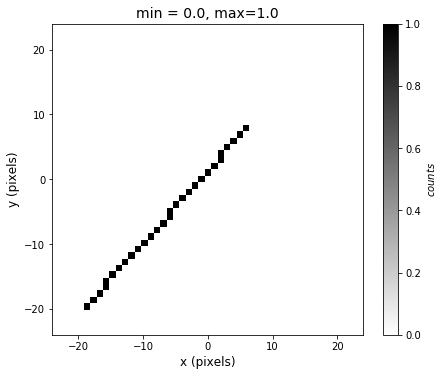

In [7]:
scale = 1
image = np.zeros((49 * scale ,49 * scale), dtype=np.float64)
lin = line_nd((3.9 * scale, 4.9 * scale), (31.9 * scale, 30.1 * scale), endpoint=True)
image[lin] = 1
print(np.sum(image))
plotCutout(image)

In [57]:
#def source_line(xdim, ydim, xt, yt, xh, yh, os_fac=1):
#    """Make a line in a pixel array"""
#    image = np.zeros((int(xdim * os_fac), int(ydim * os_fac)), dtype=np.float64)
#    rr, cc, w = line_aa(yt*os_fac, xt*os_fac, yh*os_fac, xh*os_fac)
#    image[rr,cc] = w
#    return image / image.sum()

# Uses line_nd, allowing non-integer line endpoints.
def source_line(xdim, ydim, xt, yt, xh, yh, os_fac=1):
    """Make a line in a pixel array"""
    image = np.zeros((int(xdim * os_fac), int(ydim * os_fac)), dtype=np.float64)
    coords = line_nd((yt*os_fac, xt*os_fac), (yh*os_fac, xh*os_fac), endpoint=True)
    image[coords] = 1
    return image / image.sum()

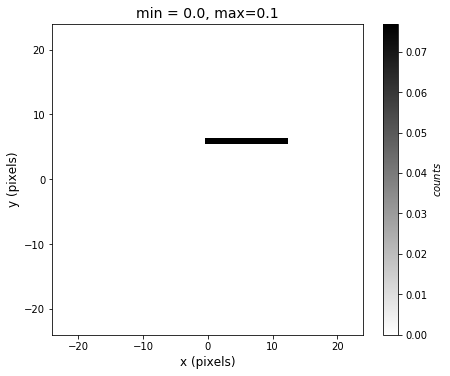

In [134]:
dims = np.array([49,49]) * scale
P0 = np.array([24.,30.]) * scale 
P1 = np.array([36.,30.]) * scale

# Plot data
data = source_line(*dims, *P0, *P1)
plotCutout(data)

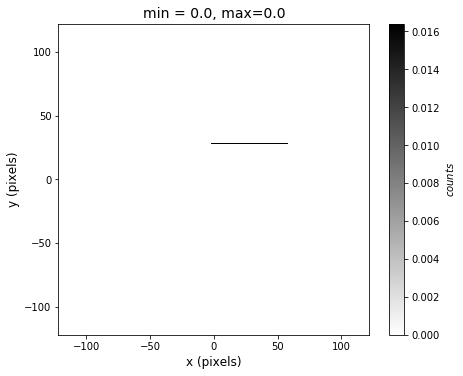

In [135]:
# Make over sampled data
os_fac = 5 # Over sample factor
data_os = source_line(*dims,*P0,*P1,os_fac=os_fac)
plotCutout(data_os)

In [136]:
def psf_kernel(xdim, ydim, sigma):
    """
    Point-spread function convolution kernel. 
    Double guassian, centered at 0,0.
    """
    
    # Pixel locations, center at 0,0
    x = np.arange(-xdim//2 + 1, xdim//2 + 1)
    y = np.arange(-ydim//2 + 1, ydim//2 + 1)
    
    # Calculate psf over each pixel
    r = np.sqrt((x[:, None])**2 + (y[None, :])**2)
    psf = np.exp(-r**2./2./sigma) / (2*np.pi*sigma)
    
    return psf

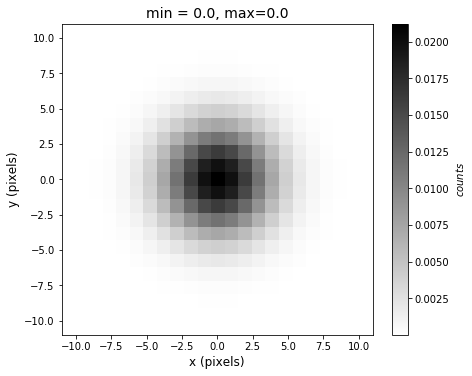

In [170]:
# Make psf with same over sampling
sigma = 1.5 * os_fac
psf = psf_kernel(int(3*sigma+1), int(3*sigma+1), sigma)
plotCutout(psf)

0.9999516458630622
1.0


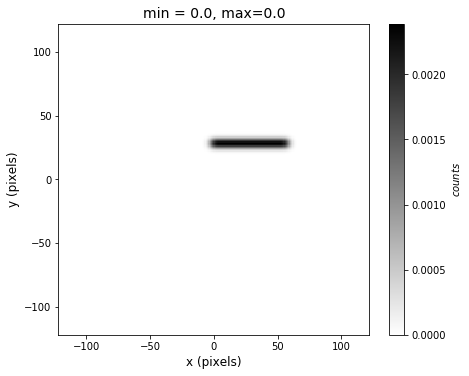

In [171]:
# Now, convolve data image with psf.
data_con_os = ndimage.convolve(data_os, psf, mode='constant', cval=0.0)
print(np.sum(data_con_os))
print(np.sum(data_os))
plotCutout(data_con_os)

0.9999516458630622


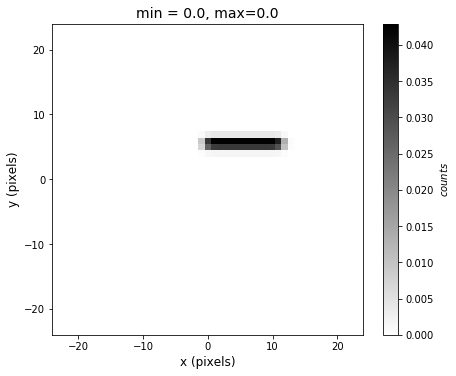

In [172]:
# Now, down sample back to original image resolution
data_processed = data_con_os.reshape(dims[0], os_fac, dims[1], os_fac).sum(3).sum(1)
print(np.sum(data_processed))
plotCutout(data_processed)

In [173]:
def trailed_model(params, xdim, ydim, os_fac):
    F, x0, y0, x1, y1 = params
    sigma = 1.5 * os_fac
    model = source_line(xdim,ydim,x0,y0,x1,y1,os_fac=os_fac)
    psf = psf_kernel(int(3*sigma+1), int(3*sigma+1), sigma)
    model_con = ndimage.convolve(model, psf, mode='constant', cval=0.0)
    model = model_con.reshape(xdim, os_fac, ydim, os_fac).sum(3).sum(1)
    
    return F * model + 1

In [214]:
scale = 1
flux = 12000.2
dims = np.array([49,49]) * scale
P0 = np.array([24.,30.]) * scale 
P1 = np.array([36.,36.]) * scale

params = np.array([flux,*P0,*P1])

In [215]:
%%time
model = trailed_model(params,*dims,os_fac)

CPU times: user 39 ms, sys: 3 µs, total: 39 ms
Wall time: 37.8 ms


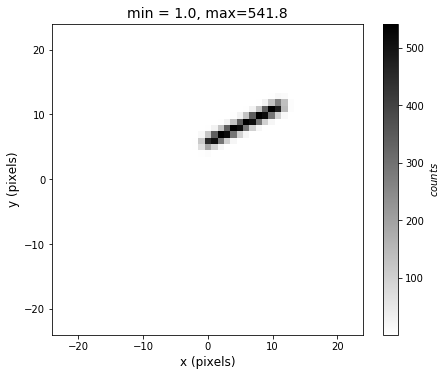

In [216]:
plotCutout(model)

In [177]:
from scipy.optimize import minimize, least_squares

In [178]:
# Try a chi-squared minimization
def chi_squared(params, data, os_fac):
    """Chi-squared function"""
    dims = data.shape
    model = trailed_model(params, *dims, os_fac)
    return np.sum((model - data)**2. / model)

In [179]:
chi_squared(params, model, os_fac)

0.0

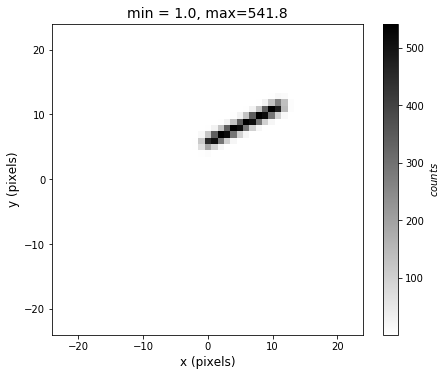

In [217]:
data = trailed_model(params,*dims,os_fac)
plotCutout(data)

In [233]:
%%time
p0 = np.array([12005.2,24.1,30.1,36.1,36.1])
res = minimize(chi_squared, p0, args=(data,os_fac), method='Nelder-Mead', tol=1e-11)

CPU times: user 18.4 s, sys: 2 µs, total: 18.4 s
Wall time: 18.4 s


Reduced Chi-squared:  0.040865727944575
Flux :  12048.832227493203
x1 :  24.086074627132085
y1 :  30.06381738983409
x2 :  36.17735275703001
y2 :  36.081902289034076


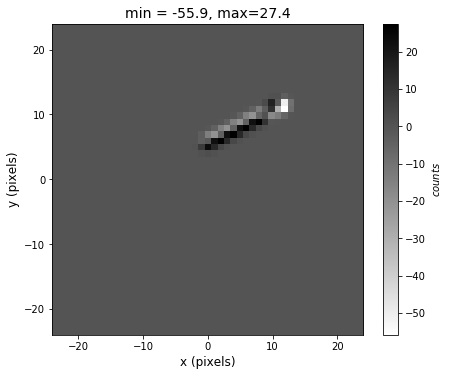

In [234]:
image_fit = trailed_model(res.x, *dims, os_fac)
names = ["Flux", "x1", "y1", "x2", "y2"]
print("Reduced Chi-squared: ", res.fun / (data.size - 1))
[print(n,": ",x) for x,n in np.stack([res.x,names],axis=1) ]
plotCutout(data - image_fit)

In [224]:
# Try a chi-squared minimization
def chi_squared_grid(F, x0, y0, x1, y1):
    """Chi-squared function (for grid eval)"""
    dims = (49,49)
    params = np.array([F, x0, y0, x1, y1])
    model = trailed_model(params, *dims, 5)
    return np.sum((model - data)**2. / model)

In [229]:
# Solve chi-squared on a grid of parameters
F0 = 12000.2; fb = 20
x0 = 24.; xb = 2
y0 = 30.; yb = 2
x1 = 36.;
y1 = 36.;

N = 5
F  = np.arange(F0 - fb, F0 + fb, 2*fb/N)
x0 = np.arange(x0 - xb, x0 + xb, 2*xb/N)
y0 = np.arange(y0 - yb, y0 + yb, 2*yb/N)
x1 = np.arange(x1 - xb, x1 + xb, 2*xb/N)
y1 = np.arange(y1 - yb, y1 + yb, 2*yb/N)
Fs, x0s, y0s, x1s, y1s = np.meshgrid(F,x0,y0,x1,y1)

chi2 = np.vectorize(chi_squared_grid)(Fs, x0s, y0s, x1s, y1s)    

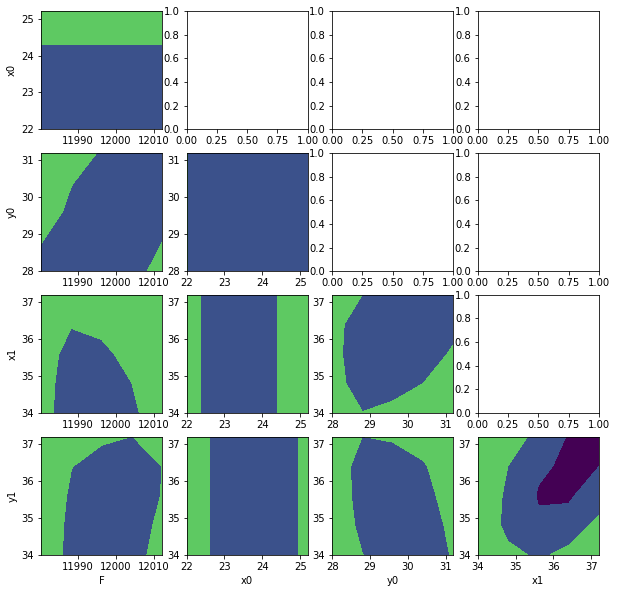

In [230]:
from matplotlib.colors import LogNorm

fig,axs = plt.subplots(4,4, figsize=(10, 10))
levels = 100; c = 'k'; names = np.array(["F","x0","y0","x1","y1"])
n = LogNorm(); ind = 1
axs[0,0].contourf(F,x0,chi2[:,:,ind,ind,ind],levels,norm=n)
axs[1,0].contourf(F,y0,chi2[:,ind,:,ind,ind],levels,norm=n)
axs[2,0].contourf(F,x1,chi2[:,ind,ind,:,ind],levels,norm=n)
axs[3,0].contourf(F,y1,chi2[:,ind,ind,ind,:],levels,norm=n)

axs[1,1].contourf(x0,y0,chi2[ind,:,:,ind,ind],levels,norm=n)
axs[2,1].contourf(x0,x1,chi2[ind,:,ind,:,ind],levels,norm=n)
axs[3,1].contourf(x0,y1,chi2[ind,:,ind,ind,:],levels,norm=n)

axs[2,2].contourf(y0,x1,chi2[ind,ind,:,:,ind],levels,norm=n)
axs[3,2].contourf(y0,y1,chi2[ind,ind,:,ind,:],levels,norm=n)

axs[3,3].contourf(x1,y1,chi2[ind,ind,ind,:,:],levels,norm=n)
[axs[i,0].set_ylabel(n) for i,n in zip(range(4),names[1:])]
[axs[3,i].set_xlabel(n) for i,n in zip(range(4),names[:4])];

plt.savefig('corner.pdf')